# Validation of Sensitivity and Fidelity Metrics

These metrics are designed to measure the robustness of ML explanations. 

Before using them to analyse properties of real life datasets, it seems sensible to spend some time validating their results are reasonable. 

In [1]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random
import json

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [3]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor
from model.model_creation import create_fit_model

from data.classification_spam.spambase_helpers import get_names, get_metadata

Sensitivity module imported
Dataset converter module imported
Metadata module imported
Infidelity module imported
Feature columns module imported


## 1) Multiple runs

Calculate the metrics multiple times, with freshly compiled models. Do we get consistent results? 

We use the 'spambase' dataset for this, as the model generated by Tensorflow is more consistent than than for the bank dataset. 

### 1) Multiple runs

Conclusion: sensitivities appear to vary somewhat arbitrarily. This may be due to different model configurations. 

Fidelities for explanations with similar salient features are similar. This is encouraging. 

It will be interesting to run this for a larger sample and compare fidelities and sensitivities. 

Iris dataset will be useful for further validating - this is a weakly correlated, unbalanced dataset, and so model outputs can look quite different between fittings. 

In [4]:
# Import bank dataset and build model - see 'classification_bank' for full/commented code
csv_file = 'data/classification_spam/spambase.data'
feature_names = get_names()
dataframe = pd.read_csv(csv_file, index_col=False, sep=',', names=feature_names)

metadata = get_metadata()
metadata = append_indices(metadata)
metadata = append_baselines(metadata, dataframe)

train_df, test_df = train_test_split(dataframe, test_size=0.2)

batch_size = 100
train_ds = convert_df_dataset(train_df, 'class', batch_size=batch_size)
test_ds = convert_df_dataset(test_df, 'class', shuffle=False, batch_size=batch_size)

feature_columns = []
numeric_features_to_use = get_feature_names_of_type('numerical', metadata)
normalization_parameters = get_normalization_parameters(train_df, numeric_features_to_use)
numeric_feature_columns = create_numeric_columns(train_df, numeric_features_to_use, normalization_parameters)
feature_columns += numeric_feature_columns

input_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer

model = tf.keras.Sequential([
  input_layer,
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(1, activation='sigmoid')
])

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

# Compile and train our model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)


In [5]:
# Set optimal constants for SHAP explanations
NUM_REFERENCE_VALUES = 50
NUM_PERTURBATIONS = 500

def shap_predictor_factory(feature_names, model):
    def predictor(instance):
        input_tensor = convert_numpy_tensor(instance, feature_names)
        return model.predict(input_tensor)
    return predictor

def get_explainer(predict_wrapper, dataframe_local, num_reference_values=50):
    # This never takes significant time - just calculating background values
    return shap.KernelExplainer(predict_wrapper, dataframe_local.iloc[:num_reference_values,:])

def generate_explanation(explainer, dataframe_local, index_to_explain, model_local, num_perturbations=500, chart=False, feature_names=[]):
    # Running time is O(num_reference_values * num_perturbations)
    global _shap_model
    _shap_model = model_local
    shap_values = explainer.shap_values(dataframe_local.iloc[index_to_explain,:], nsamples=num_perturbations)
    if chart == True:
        shap.summary_plot(np.array(shap_values), feature_names=feature_names, plot_type="bar")
    return shap_values

# Allows us to predict a value for a specific instance
def predict_wrapper(model, instance, feature_names):
    input_tensor = convert_numpy_tensor(instance, feature_names)
    return model.predict(input_tensor)

feature_names = get_feature_names(metadata)

In [6]:
# Our external sensitivity metric shouldn't have to know about implementation of the explanation
def simple_explainer_factory(explainer, num_perturbations=NUM_PERTURBATIONS):
    def explainer_simple(this_instance):
        return explainer.shap_values(this_instance, nsamples=num_perturbations)[0]
    return explainer_simple

# Our fidelity function expects a model with a predict() attribute that just takes an array of numbers
class ModelForFidelity():
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
    def predict(self, instance):
        return predict_wrapper(self.model, [instance], self.feature_names)


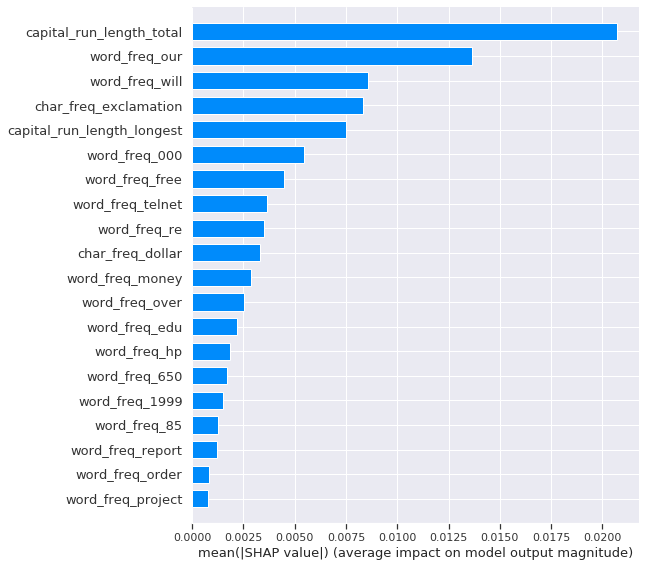

In [7]:
index_to_explain = 388
feature_names = get_feature_names(metadata)

models = []
outputs = []
shap_values = []
sensitivities = []
infidelities = []
for _ in range (1):
    
    # Build model
    metrics_test_model, _ = create_fit_model(train_ds, input_layer, METRICS, epochs=10, verbose=0)
    models.append(metrics_test_model)
    
    # Get model output
    metrics_test_instance = convert_dataframe_numpy(dataframe, index_to_explain)
    metrics_test_output = predict_wrapper(metrics_test_model, metrics_test_instance, feature_names)
    outputs.append(metrics_test_output)
    
    # Generate explanation
    metrics_test_predictor = shap_predictor_factory(feature_names, metrics_test_model)
    metrics_test_explainer = get_explainer(metrics_test_predictor, dataframe)
    metrics_test_shap_values = generate_explanation(metrics_test_explainer, dataframe, index_to_explain, metrics_test_model, chart=False, feature_names=feature_names)
    shap_values.append(metrics_test_shap_values)
    
    # Generate metrics
    metrics_test_explainer_simple = simple_explainer_factory(metrics_test_explainer)
    metrics_test_sensitivity = calculate_sensitivity(metrics_test_explainer_simple, metrics_test_shap_values, metrics_test_instance[0], metadata)
    sensitivities.append(metrics_test_sensitivity)
    metrics_test_infidelity_model = ModelForFidelity(metrics_test_model, feature_names)
    metrics_test_infidelity = calculate_infidelity(metrics_test_shap_values[0], metrics_test_infidelity_model, metrics_test_instance[0], metadata)
    infidelities.append(metrics_test_infidelity)

In [8]:
models, outputs, shap_values, sensitivities, infidelities

# TODO - visualise these results. Work out mean, SDs etc

([<tensorflow.python.keras.engine.sequential.Sequential at 0x7f1bb440d070>],
 [array([[0.9989307]], dtype=float32)],
 [[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.01364731,
           0.00253618,  0.        ,  0.        ,  0.0008016 ,  0.        ,
           0.        , -0.00856899,  0.        ,  0.00120375,  0.        ,
           0.00446915,  0.        ,  0.        ,  0.        ,  0.        ,
           0.00025803,  0.        ,  0.00545648,  0.00285757,  0.00184527,
           0.        ,  0.        ,  0.00170718,  0.        ,  0.        ,
           0.00366104,  0.        ,  0.        ,  0.        ,  0.00124311,
           0.        ,  0.00150622,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.00075561,  0.00351699,
           0.00217559,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        , -0.00832096,  0.00328482,  0.        ,  0.        ,
           0.00749188,  0.020734  ,  0.        ])]],
 [0.0

### 2) Consider end points

Sensitivity: this is just the L2 difference between two vectors (representing the two explanations). So the minimum is zero, with no theoretical maximum. Zero represents no change to the explanation as a result of perturbations to the input. 

Fidelity: minimum is also zero, with no theoretical maximum. Zero represents the perturbation (dot) explanation, and change to model output, being identical. In practice, this is likely to mean both are zero (this can happen if the input is already baselined). 

**Conclusion**: both have clear and meaningful zero values. 

### 3) Validating SHAP completeness axiom

This is defined as - between two instances, the difference in feature importances should sum up to the difference in predicted outputs. This is important for the fidelity metric, as it implies the [perturbation (dot) explanation] and [change to model output] are comparable in scale. 

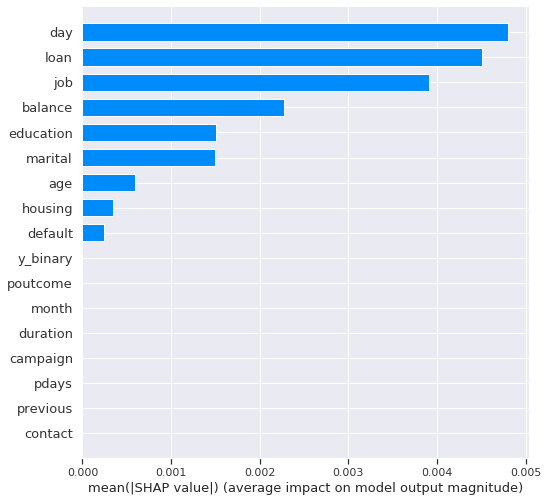

In [35]:
baseline_index = 388
other_indexes = range(389, 410)

example_model, _ = create_fit_model(train_ds, input_layer, METRICS, epochs=10, verbose=0)

baseline_instance = convert_dataframe_numpy(dataframe, baseline_index)
baseline_prediction = predict_wrapper(example_model, baseline_instance, feature_names)[0][0]
predictor = shap_predictor_factory(feature_names, example_model)
explainer = get_explainer(predictor, dataframe)
baseline_shap_values = generate_explanation(explainer, dataframe, baseline_index, example_model, chart=True, feature_names=feature_names)
baseline_SV_sum = sum(baseline_shap_values[0])

completeness_results = pd.DataFrame(columns=['prediction_difference', 'SV_sum_difference'])

for idx in other_indexes:
    instance = convert_dataframe_numpy(dataframe, idx)
    prediction_difference = predict_wrapper(example_model, instance, feature_names)[0][0] - baseline_prediction
    SV_sum_difference = sum(generate_explanation(explainer, dataframe, idx, example_model, chart=False, feature_names=feature_names)[0]) - baseline_SV_sum
    completeness_results = completeness_results.append({
        'prediction_difference': prediction_difference,
        'SV_sum_difference': SV_sum_difference
    }, ignore_index=True)

[(-0.02, 0.08477499932050706)]

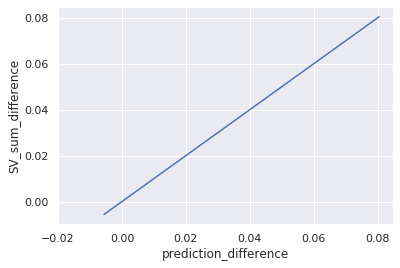

In [36]:
sns.lineplot(data=completeness_results, x="prediction_difference", y="SV_sum_difference", markers=True).set(xlim=-0.02)

# TODO: provide nonsense inputs. Read about more of the theory behind this. 

**Conclusion**: SHAP appears to be consistent with completeness axiom. 

### 4) Linear models

Set up simple linear models for both metrics, and check we get sensible results.

In [17]:
class MockLinearModel:
    def __init__(self, x1_ratio, x2_ratio):
        self.x1_ratio = x1_ratio
        self.x2_ratio = x2_ratio
    
    def predict(self, input):
        # 2D array is to replicate the TF return format
        return (input[0] * self.x1_ratio + input[1] * self.x2_ratio)
    
mock_linear_metadata = [
    {
        'name': 'x1',
        'type': 'numerical',
        'baseline': 0.5
    },
    {
        'name': 'x2',
        'type': 'numerical',
        'baseline': 0.5
    }
]

In [19]:
# Test 1: Vary explanation value for x1 (e1). Expectation - minima at x = 0.5 (baseline value, so no perturbation).
# Increases exponentially on either side due to squaring result

test1_mock_linear_results = pd.DataFrame(columns=['variable', 'value', 'infidelity'])
example_instance = [2, 6] # x1, x2
explanation_inputs = np.linspace(-2, 2, 41)

for value in explanation_inputs:
    mock_linear_model = MockLinearModel(1, 0)
    mock_explanation = [value, 0]
    mock_linear_infidelity = calculate_infidelity(mock_explanation, mock_linear_model, example_instance, mock_linear_metadata, num_baselined_features=1)
    test1_mock_linear_results = test1_mock_linear_results.append({
        'variable': 'e1',
        'value': value,
        'infidelity': mock_linear_infidelity
    }, ignore_index=True)

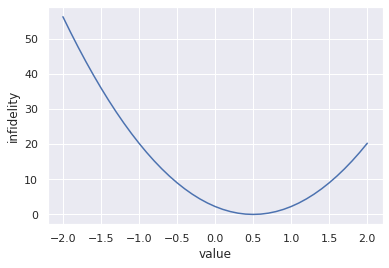

In [20]:
sns.lineplot(data=test1_mock_linear_results, x="value", y="infidelity")
# Result - in line with expectations

In [21]:
# Test 2: Vary explanation value for x2 (e2). Expectation - infidelity higher than for test 1 (as this is not the 'true' explanation)

In [24]:
test2_mock_linear_results = pd.DataFrame(columns=['variable', 'value', 'infidelity'])
example_instance = [2, 6] # x1, x2
explanation_inputs = np.linspace(-2, 2, 41)

for value in explanation_inputs:
    mock_linear_model = MockLinearModel(1, 0)
    mock_explanation = [0, value]
    mock_linear_infidelity = calculate_infidelity(mock_explanation, mock_linear_model, example_instance, mock_linear_metadata, num_baselined_features=1)
    test2_mock_linear_results = test2_mock_linear_results.append({
        'variable': 'e2',
        'value': value,
        'infidelity': mock_linear_infidelity
    }, ignore_index=True)

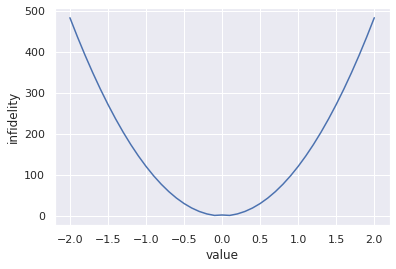

In [25]:
sns.lineplot(data=test2_mock_linear_results, x="value", y="infidelity")
# Result - in line with expectations

In [26]:
# Test 3: for sensitity, check measurements at the boundary points of a stepwise linear function are higher than
# the surrounding values

input_length = 2
reference = np.zeros(input_length)

stepwise_instance = np.array([1, 3])

mock_linear_metadata = [
    {
        'name': 'x1',
        'type': 'numerical',
        'used': True,
        'index': 0,
        'baseline': 1
    },
    {
        'name': 'x2',
        'type': 'numerical',
        'used': True,
        'index': 1,
        'baseline': 1
    }
]

# Discontinuities at x0 = 0  and x0 = 2
def stepwise_linear(inputs):
    output = np.array([])
    for inp in inputs:
        if inp[0] < 0:
            output = np.append(output, inp[1])
        elif inp[0] >= 0 and inp[0] < 2:
            output = np.append(output, inp[1] + 3)
        elif inp[0] >= 2:
            output = np.append(output, inp[1] + 6)
    return output
        
stepwise_explainer = shap.KernelExplainer(stepwise_linear, np.reshape(reference, (1, len(reference))))

FIXED_VARIABLE_VALUE = 1
stepwise_sensitivies = pd.DataFrame(columns=['variable', 'input_value', 'output_value'])
stepwise_inputs = np.linspace(-2, 4, 61)

for x0_input in stepwise_inputs:
    stepwise_input = np.array([x0_input, FIXED_VARIABLE_VALUE])
    stepwise_shap_values = stepwise_explainer.shap_values(stepwise_input)
    stepwise_linear_sensitivity = calculate_sensitivity(stepwise_explainer.shap_values, stepwise_shap_values, stepwise_input, mock_linear_metadata)
    stepwise_sensitivies = stepwise_sensitivies.append({
        'variable': 'x0',
        'input_value': x0_input,
        'output_value': stepwise_linear_sensitivity
    }, ignore_index=True)
    
for x1_input in stepwise_inputs:
    stepwise_input = np.array([FIXED_VARIABLE_VALUE, x1_input])
    stepwise_shap_values = stepwise_explainer.shap_values(stepwise_input)
    stepwise_linear_sensitivity = calculate_sensitivity(stepwise_explainer.shap_values, stepwise_shap_values, stepwise_input, mock_linear_metadata)
    stepwise_sensitivies = stepwise_sensitivies.append({
        'variable': 'x1',
        'input_value': x1_input,
        'output_value': stepwise_linear_sensitivity
    }, ignore_index=True)

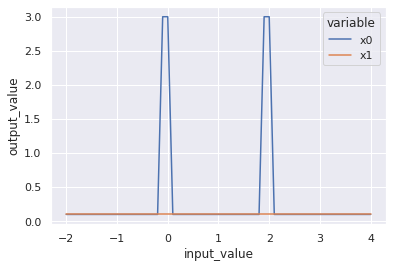

In [27]:
sns.lineplot(data=stepwise_sensitivies, x="input_value", y="output_value", hue="variable")
# Result - in line with expectations

**Conclusion**:
* Linear models are in line with expectations. 
* Fidelity measurement is flawed, in that inputs near the baseline will tend to zero. Thinking needed about how to handle this. 

### 5) Iris Dataset

Aim - make sure the metrics coming from Iris dataset are sensible. 

Code from SHAP documentation, where Iris dataset used as an example. 

In [39]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import time

X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars


In [40]:
iris_metadata = [
    {
        'name': 'sepal length (cm)',
        'type': 'numerical',
        'baseline': 0.5,
        'used': True
    },
    {
        'name': 'sepal width (cm)',
        'type': 'numerical',
        'baseline': 0.5,
        'used': True
    },
    {
        'name': 'petal length (cm)',
        'type': 'numerical',
        'baseline': 0.5,
        'used': True
    },
    {
        'name': 'petal width (cm)',
        'type': 'numerical',
        'baseline': 0.5,
        'used': True
    }
]

# Append indexes to metadata
iris_metadata = append_indices(iris_metadata)
    
# Append baselines to metadata
iris_metadata = append_baselines(iris_metadata, X_train)

In [44]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

iris_explainer = shap.KernelExplainer(nn.predict_proba, X_train)
# Note - this gives us SHAP values for each class prediction
iris_shap_values = iris_explainer.shap_values(X_test.iloc[0,:].to_numpy())
iris_shap_values

Accuracy = 100.0%


Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[array([ 0.01284576, -0.00650377, -0.30335958, -0.02819091]),
 array([-0.01909622,  0.00194292,  0.13780117, -0.42683336]),
 array([0.00625046, 0.00456085, 0.16555841, 0.45502427])]

In [45]:
iris_sensitivity = calculate_sensitivity(iris_explainer.shap_values, iris_shap_values, X_test.iloc[0,:].to_numpy(), iris_metadata)
iris_sensitivity

0.08801154295366526

In [46]:
# Uncertainty is the degree to which the model is unsure of the outcome
# Idea is that, the higher the uncertainty, the higher sensitivity should be

def get_iris_uncertainty_and_sensitivity(instance):
    predictions = nn.predict_proba(instance)
    highest_prediction = max(predictions[0])
    highest_prediction_index = np.where(predictions[0] == highest_prediction)[0][0]
    uncertainty_index = 1 - highest_prediction
    
    # We now focus entirely on the 'highest_prediction_index'
    def highest_explainer(loc_instance):
        return iris_explainer.shap_values(loc_instance)[highest_prediction_index]
    
    shap_values = iris_explainer.shap_values(instance[0])[highest_prediction_index]
    sensitivity = calculate_sensitivity(highest_explainer, shap_values, instance[0], iris_metadata)
    
    return uncertainty_index, sensitivity

get_iris_uncertainty_and_sensitivity([X_test.iloc[0,:].to_numpy()])

(0.00150472253098477, 0.062272847215009856)

In [47]:
iris_sensitivity_results = pd.DataFrame(columns=['index', 'uncertainty', 'sensitivity'])

for idx in range(len(X_train)):
    uncertainty, sensitivity = get_iris_uncertainty_and_sensitivity([X_train.iloc[idx,:].to_numpy()])
    iris_sensitivity_results = iris_sensitivity_results.append({
        'index': idx,
        'uncertainty': uncertainty,
        'sensitivity': sensitivity
    }, ignore_index=True)

In [48]:
iris_sensitivity_results

,index,uncertainty,sensitivity
0,0.0,0.070795,0.198201
1,1.0,0.013289,0.082918
2,2.0,0.000098,0.045198
3,3.0,0.113028,0.444435
4,4.0,0.001505,0.054057
...,...,...,...
115,115.0,0.000394,0.082536
116,116.0,0.021692,0.113070
117,117.0,0.001228,0.088861
118,118.0,0.001505,0.094716


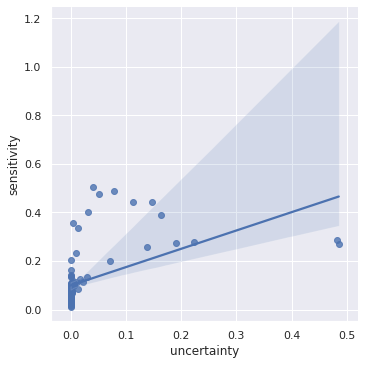

In [49]:
sns.lmplot(data=iris_sensitivity_results, x="uncertainty", y="sensitivity")

In [53]:
class FidelityModel():
    
    def __init__(self, prediction):
        self.prediction = prediction
        
    def predict(self, instance):
        return nn.predict_proba([instance])[0][self.prediction]

def get_iris_infidelity(index_to_calculate, noise=0, iterations=10):
    
    prediction = nn.predict([X_test.iloc[index_to_calculate,:].to_numpy()])[0]
    predict_wrapper = FidelityModel(prediction)

    shap_values_for_infidelity = iris_explainer.shap_values(X_test.iloc[index_to_calculate,:].to_numpy())[prediction]

    if noise == 0:
        iris_infidelity = calculate_infidelity(shap_values_for_infidelity, predict_wrapper, X_test.iloc[index_to_calculate,:].to_numpy(), iris_metadata)
        return iris_infidelity
    else: # iterations required
        max_infidelity = 0
        for _ in range(iterations):
            noisy_shap_values = [elem * random.uniform(1-noise,1+noise) for elem in shap_values_for_infidelity]
            iris_infidelity = calculate_infidelity(noisy_shap_values, predict_wrapper, X_test.iloc[index_to_calculate,:].to_numpy(), iris_metadata)
            max_infidelity = max(max_infidelity, iris_infidelity)
        return max_infidelity
    # Loop through first 10 test instances
    # For each , gradually increase the amount of noise in the explanation (make sure this is tuneable)


In [54]:
get_iris_infidelity(0, noise=0)

0.3152436049456958

In [55]:
iris_infidelity_results = pd.DataFrame(columns=['index', 'noise', 'infidelity'])

for idx in range(5):
    for noise_level in np.linspace(0, 10, 21):
        infidelity = get_iris_infidelity(idx, noise_level)
        iris_infidelity_results = iris_infidelity_results.append({
            'index': idx,
            'noise': noise_level,
            'infidelity': infidelity
        }, ignore_index=True)

In [56]:
iris_infidelity_results

,index,noise,infidelity
0,0.0,0.0,0.315244
1,0.0,0.5,0.590003
2,0.0,1.0,0.595694
3,0.0,1.5,0.546314
4,0.0,2.0,1.822018
...,...,...,...
100,4.0,8.0,7.433754
101,4.0,8.5,6.086838
102,4.0,9.0,17.805725
103,4.0,9.5,17.295236


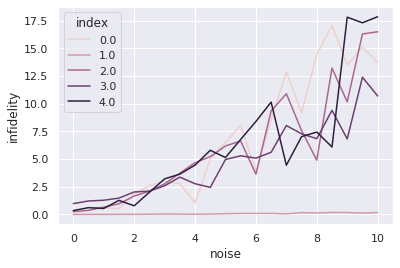

In [57]:
sns.lineplot(data=iris_infidelity_results, x="noise", y="infidelity", hue="index")

**Conclusion**: Iris dataset gives the expected results, although correlation with sensitivity is not as strong as expected. 